In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import joblib


In [2]:
training_df =  pd.read_csv("../Data/training_dataset_preprocessed.csv", sep=";")
training_df

,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,datetime,timestamp,FLOW,SPEED_MS_AVG,PORTAL_NUM,PORTAL_GROUP
0,"E4S 55,620",20210601,04:00:00,240,48,16,8,4,2021-06-01 04:00:00,2021-06-01 04:00:00,27.5,21.866455,55620,1
1,"E4S 55,620",20210601,04:01:00,241,48,16,8,4,2021-06-01 04:01:00,2021-06-01 04:01:00,34.0,21.745294,55620,1
2,"E4S 55,620",20210601,04:02:00,242,48,16,8,4,2021-06-01 04:02:00,2021-06-01 04:02:00,36.0,22.264722,55620,1
3,"E4S 55,620",20210601,04:03:00,243,48,16,8,4,2021-06-01 04:03:00,2021-06-01 04:03:00,34.0,22.370000,55620,1
4,"E4S 55,620",20210601,04:04:00,244,48,16,8,4,2021-06-01 04:04:00,2021-06-01 04:04:00,31.0,22.568387,55620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604021,"E4S 58,140",20211231,09:56:00,596,119,39,19,9,2021-12-31 09:56:00,2021-12-31 09:56:00,25.0,20.556400,58140,4
604022,"E4S 58,140",20211231,09:57:00,597,119,39,19,9,2021-12-31 09:57:00,2021-12-31 09:57:00,23.0,21.523913,58140,4
604023,"E4S 58,140",20211231,09:58:00,598,119,39,19,9,2021-12-31 09:58:00,2021-12-31 09:58:00,23.0,21.171739,58140,4
604024,"E4S 58,140",20211231,09:59:00,599,119,39,19,9,2021-12-31 09:59:00,2021-12-31 09:59:00,19.5,21.303846,58140,4


### Feature Engineering

In [4]:
import pandas as pd

# --- Pre-req: build timestamp and sort ---
training_df = training_df.copy()
training_df["timestamp"] = pd.to_datetime(
    training_df["Date"].astype(str) + " " + training_df["Time"].astype(str),
    format="%Y%m%d %H:%M:%S"
)
training_df = training_df.sort_values(["PORTAL", "timestamp"])


g = training_df.groupby("PORTAL")

# ================= INPUT FEATURES (past-only) =================
# Last 15 minutes aggregates (exclude current minute with shift(1))
training_df["FLOW_AG_15"] = g["FLOW"].transform(lambda s: s.rolling(15, min_periods=15).sum().shift(1))
training_df["SPEED_MS_AVG_AG_15"] = g["SPEED_MS_AVG"].transform(lambda s: s.rolling(15, min_periods=15).mean().shift(1))

# Last 60 minutes flow sum
training_df["FLOW_AG_60"] = g["FLOW"].transform(lambda s: s.rolling(60, min_periods=60).sum().shift(1))

# Same 15-min window yesterday / last week (row-based shifts; 24*60 and 7*24*60 rows)
training_df["FLOW_AG_1d"] = g["FLOW_AG_15"].shift(6 * 60)
training_df["FLOW_AG_1w"] = g["FLOW_AG_15"].shift(7 * 6 * 60)

# ================= TARGET (future 15-min total) =================
training_df["FLOW_TARGET_15"] = g["FLOW"].transform(lambda s: s.rolling(15, min_periods=15).sum().shift(-15))

# ================= NA report / drop for modeling =================
key_cols = [
    "FLOW_AG_15",
    "SPEED_MS_AVG_AG_15",
    "FLOW_AG_60",
    "FLOW_AG_1d",
    "FLOW_AG_1w",
    "FLOW_TARGET_15"
]

# --- Workday flag ---
training_df["IS_WORKDAY"] = (training_df["timestamp"].dt.dayofweek < 5).astype("int8")

# --- Hour of day as float  ---
training_df["HOUR_FLOAT"] = (
    training_df["timestamp"].dt.hour +
    training_df["timestamp"].dt.minute / 60.0
).astype("float32")

# Quick checks
print("Workday flag counts:\n", training_df["IS_WORKDAY"].value_counts())
print("Hour range:", training_df["HOUR_FLOAT"].min(), "to", training_df["HOUR_FLOAT"].max())

training_df["DAYOFYEAR"] = training_df["timestamp"].dt.dayofyear

# Cyclical encoding
training_df["DAYOFYEAR_SIN"] = np.sin(2 * np.pi * training_df["DAYOFYEAR"] / 365)
training_df["DAYOFYEAR_COS"] = np.cos(2 * np.pi * training_df["DAYOFYEAR"] / 365)


# Drop rows with NaN in ANY of these columns
features_training_df = training_df.dropna(subset=key_cols)


print("Any NaNs left?", features_training_df[key_cols].isna().any().any())
print("NA counts in key cols:\n", training_df[key_cols].isna().sum())
print("Model df shape:", features_training_df.shape)


Workday flag counts:
 IS_WORKDAY
1    435128
0    168898
Name: count, dtype: int64
Hour range: 4.0 to 10.0
Any NaNs left? False
NA counts in key cols:
 FLOW_AG_15              120
SPEED_MS_AVG_AG_15      120
FLOW_AG_60              480
FLOW_AG_1d             3000
FLOW_AG_1w            20280
FLOW_TARGET_15          120
dtype: int64
Model df shape: (583626, 25)


In [5]:
features_training_df

,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,datetime,timestamp,...,SPEED_MS_AVG_AG_15,FLOW_AG_60,FLOW_AG_1d,FLOW_AG_1w,FLOW_TARGET_15,IS_WORKDAY,HOUR_FLOAT,DAYOFYEAR,DAYOFYEAR_SIN,DAYOFYEAR_COS
2535,"E4S 55,620",20210608,04:08:00,248,49,16,8,4,2021-06-08 04:08:00,2021-06-08 04:08:00,...,20.979328,3097.0,677.0,539.5,690.0,1,4.133333,159,3.935903e-01,-0.919286
2536,"E4S 55,620",20210608,04:09:00,249,49,16,8,4,2021-06-08 04:09:00,2021-06-08 04:09:00,...,21.139356,3064.0,660.0,565.0,715.0,1,4.150000,159,3.935903e-01,-0.919286
2537,"E4S 55,620",20210608,04:10:00,250,50,16,8,4,2021-06-08 04:10:00,2021-06-08 04:10:00,...,21.314372,3040.0,645.0,585.0,739.0,1,4.166667,159,3.935903e-01,-0.919286
2538,"E4S 55,620",20210608,04:11:00,251,50,16,8,4,2021-06-08 04:11:00,2021-06-08 04:11:00,...,21.463672,3023.0,626.0,609.0,761.0,1,4.183333,159,3.935903e-01,-0.919286
2539,"E4S 55,620",20210608,04:12:00,252,50,16,8,4,2021-06-08 04:12:00,2021-06-08 04:12:00,...,21.618226,3006.0,608.0,626.0,791.0,1,4.200000,159,3.935903e-01,-0.919286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604006,"E4S 58,140",20211231,09:41:00,581,116,38,19,9,2021-12-31 09:41:00,2021-12-31 09:41:00,...,21.877525,787.0,503.0,229.0,281.0,1,9.683333,365,6.432491e-16,1.000000
604007,"E4S 58,140",20211231,09:42:00,582,116,38,19,9,2021-12-31 09:42:00,2021-12-31 09:42:00,...,21.969703,785.0,512.0,232.0,290.0,1,9.700000,365,6.432491e-16,1.000000
604008,"E4S 58,140",20211231,09:43:00,583,116,38,19,9,2021-12-31 09:43:00,2021-12-31 09:43:00,...,21.979833,785.0,521.0,237.0,299.0,1,9.716666,365,6.432491e-16,1.000000
604009,"E4S 58,140",20211231,09:44:00,584,116,38,19,9,2021-12-31 09:44:00,2021-12-31 09:44:00,...,21.909302,785.0,528.0,237.0,303.5,1,9.733334,365,6.432491e-16,1.000000


In [6]:
print("Date range:", features_training_df["timestamp"].min(), "→", features_training_df["timestamp"].max())


Date range: 2021-06-08 04:08:00 → 2021-12-31 09:45:00


In [7]:
print(features_training_df.dtypes.to_frame("dtype"))

                             dtype
PORTAL                      object
Date                         int64
Time                        object
Interval_1                   int64
Interval_5                   int64
Interval_15                  int64
Interval_30                  int64
Interval_60                  int64
datetime                    object
timestamp           datetime64[ns]
FLOW                       float64
SPEED_MS_AVG               float64
PORTAL_NUM                   int64
PORTAL_GROUP                 int64
FLOW_AG_15                 float64
SPEED_MS_AVG_AG_15         float64
FLOW_AG_60                 float64
FLOW_AG_1d                 float64
FLOW_AG_1w                 float64
FLOW_TARGET_15             float64
IS_WORKDAY                    int8
HOUR_FLOAT                 float32
DAYOFYEAR                    int32
DAYOFYEAR_SIN              float64
DAYOFYEAR_COS              float64


### Colinearity Check

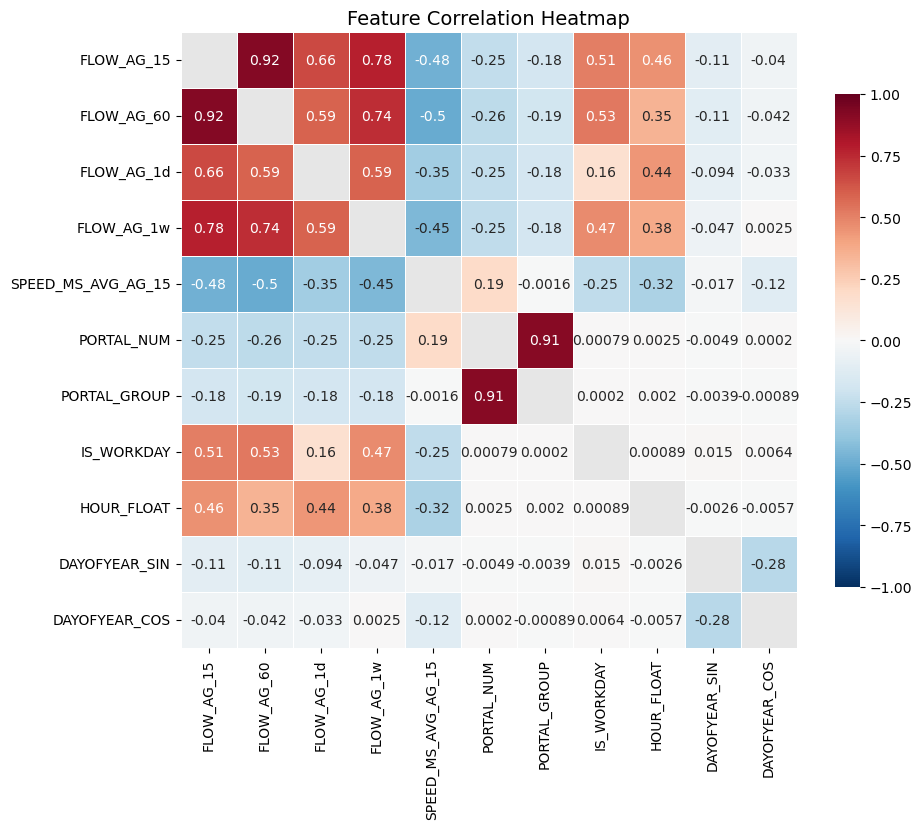

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features
numeric_features = features_training_df[[
    "FLOW_AG_15",  
    "FLOW_AG_60", 
    "FLOW_AG_1d", 
    "FLOW_AG_1w", 
    "SPEED_MS_AVG_AG_15",
    "PORTAL_NUM", 
    "PORTAL_GROUP", 
    "IS_WORKDAY",
    "HOUR_FLOAT",
    "DAYOFYEAR_SIN",
    "DAYOFYEAR_COS"
]]

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Mask the diagonal
mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(10, 8))

# Heatmap with diverging color palette: blue (-1), white (0), red (1)
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap="RdBu_r",       # diverging: red/blue
    center=0,
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

# Grey-out the diagonal
sns.heatmap(
    corr_matrix,
    mask=~mask,
    cmap=[(0.9, 0.9, 0.9)],  # light grey
    cbar=False,
    square=True,
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()


In [9]:
# Explicit feature list
keep_cols = [
    "timestamp",
    "PORTAL_GROUP",
    # 'PORTAL_NUM',
    "HOUR_FLOAT",
    "IS_WORKDAY",
    "DAYOFYEAR_SIN",
    "DAYOFYEAR_COS",
    "FLOW_AG_15",
    "FLOW_AG_1d",
    "FLOW_AG_1w",
    "SPEED_MS_AVG_AG_15",
    "FLOW_TARGET_15",
]

# Build the new dataframe with only these
no_coll_training_df = features_training_df[keep_cols].copy()

print("New no_coll_training_df shape:", no_coll_training_df.shape)
print("Columns kept:", no_coll_training_df.columns.tolist())



New no_coll_training_df shape: (583626, 11)
Columns kept: ['timestamp', 'PORTAL_GROUP', 'HOUR_FLOAT', 'IS_WORKDAY', 'DAYOFYEAR_SIN', 'DAYOFYEAR_COS', 'FLOW_AG_15', 'FLOW_AG_1d', 'FLOW_AG_1w', 'SPEED_MS_AVG_AG_15', 'FLOW_TARGET_15']


In [10]:
no_coll_training_df

,timestamp,PORTAL_GROUP,HOUR_FLOAT,IS_WORKDAY,DAYOFYEAR_SIN,DAYOFYEAR_COS,FLOW_AG_15,FLOW_AG_1d,FLOW_AG_1w,SPEED_MS_AVG_AG_15,FLOW_TARGET_15
2535,2021-06-08 04:08:00,1,4.133333,1,3.935903e-01,-0.919286,624.0,677.0,539.5,20.979328,690.0
2536,2021-06-08 04:09:00,1,4.150000,1,3.935903e-01,-0.919286,609.0,660.0,565.0,21.139356,715.0
2537,2021-06-08 04:10:00,1,4.166667,1,3.935903e-01,-0.919286,594.0,645.0,585.0,21.314372,739.0
2538,2021-06-08 04:11:00,1,4.183333,1,3.935903e-01,-0.919286,581.0,626.0,609.0,21.463672,761.0
2539,2021-06-08 04:12:00,1,4.200000,1,3.935903e-01,-0.919286,558.0,608.0,626.0,21.618226,791.0
...,...,...,...,...,...,...,...,...,...,...,...
604006,2021-12-31 09:41:00,4,9.683333,1,6.432491e-16,1.000000,219.0,503.0,229.0,21.877525,281.0
604007,2021-12-31 09:42:00,4,9.700000,1,6.432491e-16,1.000000,221.0,512.0,232.0,21.969703,290.0
604008,2021-12-31 09:43:00,4,9.716666,1,6.432491e-16,1.000000,227.0,521.0,237.0,21.979833,299.0
604009,2021-12-31 09:44:00,4,9.733334,1,6.432491e-16,1.000000,229.0,528.0,237.0,21.909302,303.5


### Normalization

In [11]:
print(no_coll_training_df.dtypes.to_frame("dtype"))

                             dtype
timestamp           datetime64[ns]
PORTAL_GROUP                 int64
HOUR_FLOAT                 float32
IS_WORKDAY                    int8
DAYOFYEAR_SIN              float64
DAYOFYEAR_COS              float64
FLOW_AG_15                 float64
FLOW_AG_1d                 float64
FLOW_AG_1w                 float64
SPEED_MS_AVG_AG_15         float64
FLOW_TARGET_15             float64


In [12]:
continuous_cols = [
    "FLOW_AG_15", "FLOW_AG_1d", "FLOW_AG_1w",
    "SPEED_MS_AVG_AG_15", "PORTAL_GROUP", "HOUR_FLOAT"
]
binary_cols = ["IS_WORKDAY","DAYOFYEAR_SIN","DAYOFYEAR_COS"]
target_col = "FLOW_TARGET_15"
feature_cols = continuous_cols + binary_cols

# Define month-end train cutoffs and the following month as validation
folds = [
    ("2021-08-31 23:59:59", "2021-09-01 00:00:00", "2021-09-30 23:59:59"),
    ("2021-09-30 23:59:59", "2021-10-01 00:00:00", "2021-10-31 23:59:59"),
    ("2021-10-31 23:59:59", "2021-11-01 00:00:00", "2021-11-30 23:59:59"),
    ("2021-11-30 23:59:59", "2021-12-01 00:00:00", "2021-12-31 23:59:59"),
]

cv_data = []

for i, (train_end, val_start, val_end) in enumerate(folds, start=1):
    train_end = pd.Timestamp(train_end)
    val_start = pd.Timestamp(val_start)
    val_end   = pd.Timestamp(val_end)

    train_mask = no_coll_training_df["timestamp"] <= train_end
    val_mask   = (no_coll_training_df["timestamp"] >= val_start) & (no_coll_training_df["timestamp"] <= val_end)

    X_train_raw = no_coll_training_df.loc[train_mask, feature_cols]
    y_train     = no_coll_training_df.loc[train_mask, target_col].values

    X_val_raw   = no_coll_training_df.loc[val_mask, feature_cols]
    y_val       = no_coll_training_df.loc[val_mask, target_col].values

    preprocessor = ColumnTransformer(
        transformers=[
            ("scale", StandardScaler(), continuous_cols),
            ("keep",  "passthrough",   binary_cols)
        ]
    )

    training_X = preprocessor.fit_transform(X_train_raw)  # fit on train only
    training_y = y_train

    X_val_proc = preprocessor.transform(X_val_raw)
    y_val_proc = y_val

    cv_data.append({
        "fold": i,
        "train_end": train_end, "val_start": val_start, "val_end": val_end,
        "training_X": training_X, "training_y": training_y,
        "X_val": X_val_proc, "y_val": y_val_proc,
        "preprocessor": preprocessor  # keep if you want to inspect later
    })

    print(f"Fold {i}: train {X_train_raw.shape[0]} rows → val {X_val_raw.shape[0]} rows")



Fold 1: train 239816 rows → val 83968 rows
Fold 2: train 323784 rows → val 86386 rows
Fold 3: train 410170 rows → val 84623 rows
Fold 4: train 494793 rows → val 88833 rows


## Building Model

### Linear Regression

In [13]:
results = []

for fold in cv_data:
    # Unpack data
    X_train, y_train = fold["training_X"], fold["training_y"]
    X_val, y_val     = fold["X_val"], fold["y_val"]

    # Train linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on validation
    y_pred = model.predict(X_val)

    # Metrics
    rmse = root_mean_squared_error(y_val, y_pred)
    mae  = mean_absolute_error(y_val, y_pred)
    r2   = r2_score(y_val, y_pred)

    results.append({"fold": fold["fold"], "rmse": rmse, "mae": mae,"r2": r2})

    print(f"Fold {fold['fold']} | RMSE={rmse:.2f} | MAE={mae:.2f} | R2={r2:.2f}")

# --- Summary ---
rmse_avg = np.mean([r["rmse"] for r in results])
mae_avg  = np.mean([r["mae"] for r in results])
r2_avg = np.mean([r["r2"] for r in results])

print("\n=== Linear Regression CV Summary ===")
print(f"Avg RMSE: {rmse_avg:.2f}")
print(f"Avg MAE : {mae_avg:.2f}")
print(f"Avg R2 : {r2_avg:.2f}")


Fold 1 | RMSE=138.09 | MAE=87.83 | R2=0.80
Fold 2 | RMSE=133.33 | MAE=83.11 | R2=0.83
Fold 3 | RMSE=150.69 | MAE=91.28 | R2=0.79
Fold 4 | RMSE=131.69 | MAE=77.95 | R2=0.81

=== Linear Regression CV Summary ===
Avg RMSE: 138.45
Avg MAE : 85.04
Avg R2 : 0.81


In [14]:
X_all_raw = no_coll_training_df.loc[:, feature_cols]
y_all     = no_coll_training_df[target_col].values

# Fit a preprocessor on ALL training data
full_preprocessor = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), continuous_cols),
        ("keep",  "passthrough",   binary_cols)
    ]
)

X_all = full_preprocessor.fit_transform(X_all_raw)

final_model = LinearRegression()
final_model.fit(X_all, y_all)

joblib.dump(full_preprocessor, "../Models/preprocessor.pkl")
joblib.dump({"feature_cols": feature_cols,
             "continuous_cols": continuous_cols,
             "binary_cols": binary_cols}, "../Models/meta.pkl")

['../Models/meta.pkl']

In [15]:
coefs = model.coef_
intercept = model.intercept_

feature_names = feature_cols  # your continuous + binary columns
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values(by="coefficient", key=abs, ascending=False)

coef_df

,feature,coefficient
0,FLOW_AG_15,253.334073
6,IS_WORKDAY,49.502421
2,FLOW_AG_1w,18.086392
3,SPEED_MS_AVG_AG_15,7.639726
4,PORTAL_GROUP,-7.050886
7,DAYOFYEAR_SIN,-5.369663
5,HOUR_FLOAT,4.725316
1,FLOW_AG_1d,3.336384
8,DAYOFYEAR_COS,2.197895


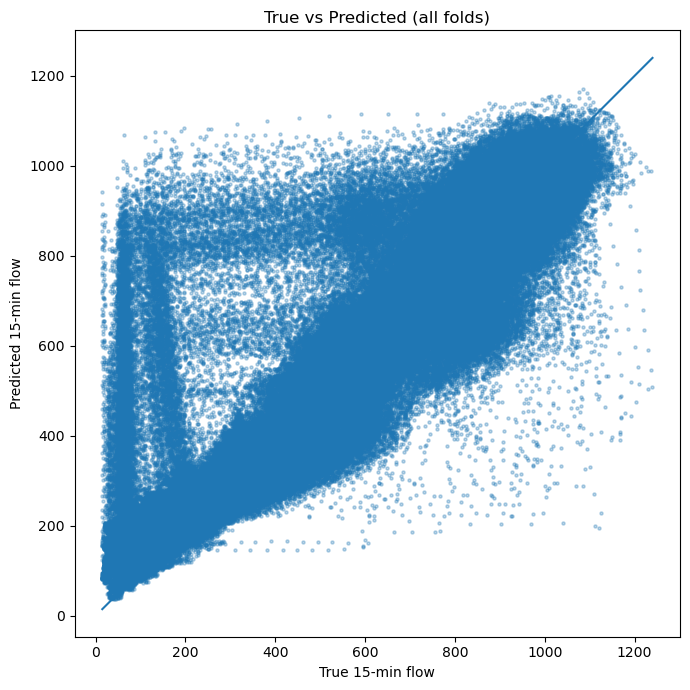

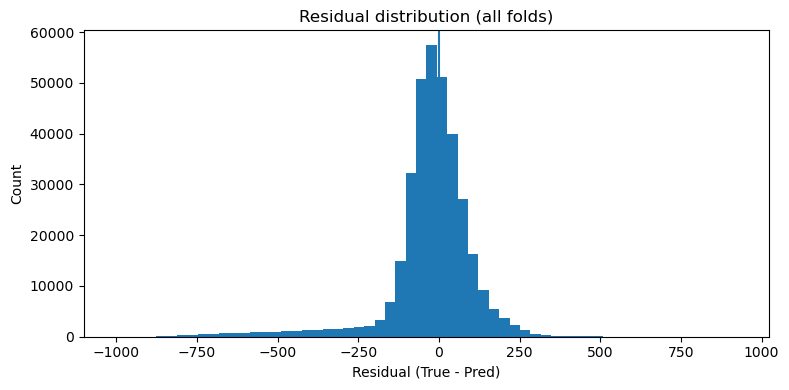

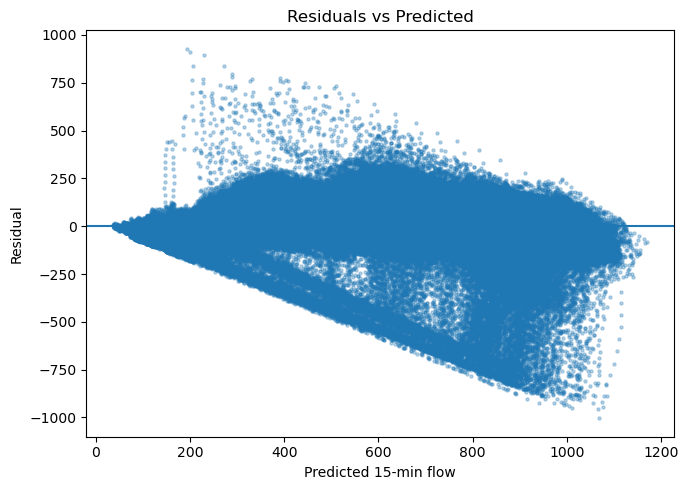

In [16]:
# --- collect predictions across folds  ---
y_true_all, y_pred_all, fold_ids = [], [], []
rmse_per_fold, mae_per_fold, r2_per_fold = [], [], []

for fd in cv_data:
    X_tr, y_tr = fd["training_X"], fd["training_y"]
    X_va, y_va = fd["X_val"], fd["y_val"]

    model = LinearRegression().fit(X_tr, y_tr)
    y_hat = model.predict(X_va)

    # stash
    y_true_all.append(y_va)
    y_pred_all.append(y_hat)
    fold_ids.extend([fd["fold"]] * len(y_va))

    rmse_per_fold.append((fd["fold"], root_mean_squared_error(y_va, y_hat)))
    mae_per_fold.append((fd["fold"], mean_absolute_error(y_va, y_hat)))
    r2_per_fold.append((fd["fold"], r2_score(y_va, y_hat)))


y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
fold_ids    = np.array(fold_ids)

# ========== PLOTS ==========

# 1) True vs Predicted (scatter + y=x)
plt.figure(figsize=(7,7))
plt.scatter(y_true_all, y_pred_all, s=5, alpha=0.3)
mn = float(min(y_true_all.min(), y_pred_all.min()))
mx = float(max(y_true_all.max(), y_pred_all.max()))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True 15-min flow")
plt.ylabel("Predicted 15-min flow")
plt.title("True vs Predicted (all folds)")
plt.tight_layout()
plt.show()

# 2) Residual histogram
res = y_true_all - y_pred_all
plt.figure(figsize=(8,4))
plt.hist(res, bins=60)
plt.axvline(0)
plt.xlabel("Residual (True - Pred)")
plt.ylabel("Count")
plt.title("Residual distribution (all folds)")
plt.tight_layout()
plt.show()

# 3) Residuals vs Predicted (heteroskedasticity check)
plt.figure(figsize=(7,5))
plt.scatter(y_pred_all, res, s=5, alpha=0.3)
plt.axhline(0)
plt.xlabel("Predicted 15-min flow")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()



### XG Boost

In [17]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import numpy as np

y_true_all, y_pred_all, fold_ids = [], [], []
rmse_per_fold, mae_per_fold,r2_per_fold = [], [], []



for fd in cv_data:
    X_tr, y_tr = fd["training_X"], fd["training_y"]
    X_va, y_va = fd["X_val"], fd["y_val"]

    model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=5000,        
        learning_rate=0.02,     
        max_depth=6,         
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=1,    
        tree_method="hist",
        eval_metric=["rmse", "mae", "mape"],
        random_state=42,
        n_jobs=-1,
    )
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        verbose=False
    )   


    y_hat = model.predict(X_va)

    y_true_all.append(y_va); y_pred_all.append(y_hat)
    fold_ids.extend([fd["fold"]] * len(y_va))

    print("RMSE", root_mean_squared_error(y_va, y_hat))
    print("MAE", mean_absolute_error(y_va, y_hat))
    print("R2", r2_score(y_va, y_hat))
    rmse_per_fold.append((fd["fold"], root_mean_squared_error(y_va, y_hat)))
    mae_per_fold.append((fd["fold"], mean_absolute_error(y_va, y_hat)))
    r2_per_fold.append((fd["fold"], r2_score(y_va, y_hat)))


y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
fold_ids    = np.array(fold_ids)

rmse_avg = np.mean([rmse for _, rmse in rmse_per_fold])
mae_avg  = np.mean([mae for _, mae in mae_per_fold])
r2_avg  = np.mean([r2 for _, r2 in r2_per_fold])


print(f"Avg RMSE: {rmse_avg:.2f}")
print(f"Avg MAE : {mae_avg:.2f}")
print(f"Avg R2 : {r2_avg:.2f}")




RMSE 72.53889557675305
MAE 50.89482051808893
R2 0.9457481073866767
RMSE 74.07729600782714
MAE 49.350092906150394
R2 0.9484432327739011
RMSE 104.6263330504507
MAE 75.81263720133506
R2 0.8996076844799301
RMSE 70.44190600042272
MAE 49.038397324252244
R2 0.9463116513964076
Avg RMSE: 80.42
Avg MAE : 56.27
Avg R2 : 0.94


In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np
from itertools import product
from xgboost.callback import EarlyStopping

# ---- 1) Define your grid (tweak as you like) ----
param_grid = {
    "learning_rate":     [0.03, 0.1],     # small vs moderate step size
    "max_depth":         [4, 6],          # shallow vs deeper trees
    "subsample":         [0.8, 1.0],      # slight randomness
    "colsample_bytree":  [0.8, 1.0],      # feature sampling
    "min_child_weight":  [1, 5],          # regularization (split sensitivity)
}


def iterate_param_grid(grid):
    keys = list(grid.keys())
    for values in product(*[grid[k] for k in keys]):
        yield dict(zip(keys, values))

# ---- 2) Grid search over your folds ----
results = []  # will store dicts with params + metrics

for params in iterate_param_grid(param_grid):
    fold_rmses, fold_maes, fold_r2s = [], [], []

    for fd in cv_data:
        X_tr, y_tr = fd["training_X"], fd["training_y"]
        X_va, y_va = fd["X_val"], fd["y_val"]

        model = XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1,
            eval_metric="rmse",
            tree_method="hist",
            n_estimators=3000,          # big; ES will stop earlier
            **params
        )
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False,
    
        )

        y_hat = model.predict(X_va)
        fold_rmses.append(root_mean_squared_error(y_va, y_hat))
        fold_maes.append(mean_absolute_error(y_va, y_hat))
        fold_r2s.append(r2_score(y_va, y_hat))

    res = {
        "params": params,
        "rmse_mean": float(np.mean(fold_rmses)),
        "rmse_std":  float(np.std(fold_rmses)),
        "mae_mean":  float(np.mean(fold_maes)),
        "r2_mean":   float(np.mean(fold_r2s)),
    }
    results.append(res)

# ---- 3) Rank by RMSE (lower is better) and show a small leaderboard ----
results_sorted = sorted(results, key=lambda d: d["rmse_mean"])
top_k = 10
print(f"\nTop {top_k} parameter sets (by mean RMSE across folds):")
for i, r in enumerate(results_sorted[:top_k], 1):
    p = r["params"]
    print(
        f"{i:2d}) RMSE={r['rmse_mean']:.4f} (±{r['rmse_std']:.4f}) | "
        f"MAE={r['mae_mean']:.4f} | R2={r['r2_mean']:.4f} | "
        f"params={p}"
    )

best = results_sorted[0]
best_params = best["params"]
print("\nBest params:", best_params)
print(
    f"Best CV metrics → RMSE={best['rmse_mean']:.4f} (±{best['rmse_std']:.4f}), "
    f"MAE={best['mae_mean']:.4f}, R2={best['r2_mean']:.4f}"
)


In [20]:
X_all_raw = no_coll_training_df.loc[:, feature_cols]
y_all     = no_coll_training_df[target_col].values

# Fit a preprocessor on ALL training data
full_preprocessor = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), continuous_cols),
        ("keep",  "passthrough",   binary_cols)
    ]
)

X_all = full_preprocessor.fit_transform(X_all_raw)

# best_model = XGBRegressor(
#     objective="reg:squarederror",
#     random_state=42,
#     n_jobs=-1,
#     eval_metric="rmse",
#     **best_params
# )
# best_model_xgb = XGBRegressor(
#     objective="reg:squarederror",
#     n_estimators=600,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1.0,
#     random_state=42,
#     n_jobs=-1,
#     eval_metric="rmse"
# )

best_model_xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=5000,         # big cap
    learning_rate=0.02,        # smaller step
    max_depth=6,               # often sweet spot on tabular
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1,        # let leaves specialize a bit
    tree_method="hist",
    eval_metric=["rmse", "mae", "mape"],
    random_state=42,
    n_jobs=-1,
)




best_model_xgb.fit(X_all, y_all)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae', 'mape'],
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=-1,
             num_parallel_tree=None, ...)

In [21]:
import joblib

# After training:
joblib.dump(best_model_xgb, "../Models/xgb_model.pkl")


['../Models/xgb_model.pkl']

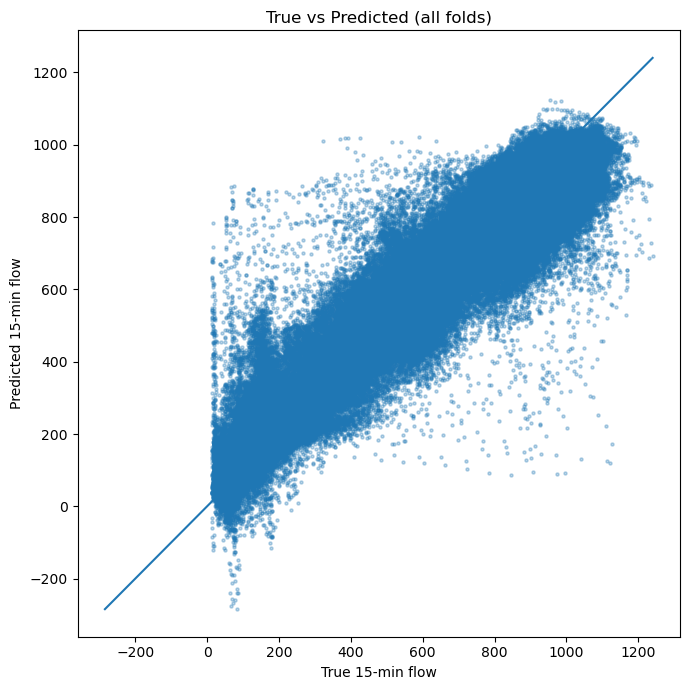

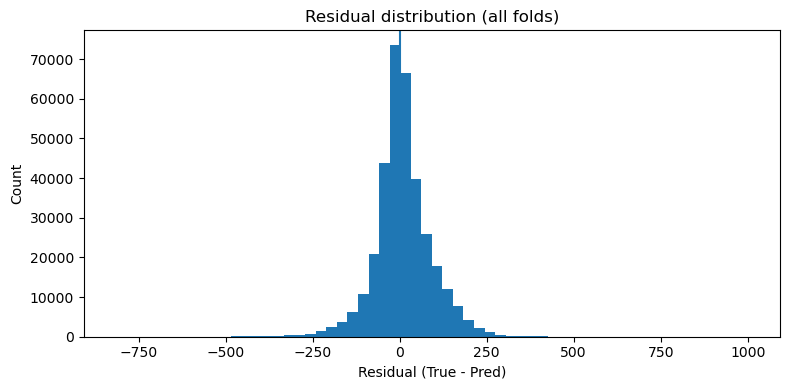

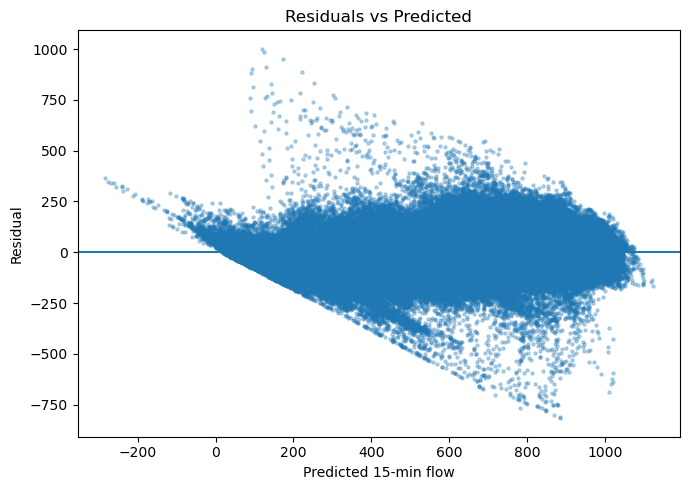

In [41]:


# ========== PLOTS ==========
# 1) True vs Predicted (scatter + y=x)
plt.figure(figsize=(7,7))
plt.scatter(y_true_all, y_pred_all, s=5, alpha=0.3)
mn = float(min(y_true_all.min(), y_pred_all.min()))
mx = float(max(y_true_all.max(), y_pred_all.max()))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True 15-min flow")
plt.ylabel("Predicted 15-min flow")
plt.title("True vs Predicted (all folds)")
plt.tight_layout()
plt.show()

# 2) Residual histogram
res = y_true_all - y_pred_all
plt.figure(figsize=(8,4))
plt.hist(res, bins=60)
plt.axvline(0)
plt.xlabel("Residual (True - Pred)")
plt.ylabel("Count")
plt.title("Residual distribution (all folds)")
plt.tight_layout()
plt.show()

# 3) Residuals vs Predicted (heteroskedasticity check)
plt.figure(figsize=(7,5))
plt.scatter(y_pred_all, res, s=5, alpha=0.3)
plt.axhline(0)
plt.xlabel("Predicted 15-min flow")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()







### Neural Networks

In [42]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true_all, y_pred_all, fold_ids = [], [], []
rmse_per_fold, mae_per_fold, r2_per_fold = [], [], []

for fd in cv_data:
    X_tr, y_tr = fd["training_X"], fd["training_y"]
    X_va, y_va = fd["X_val"], fd["y_val"]

    mlp = MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        alpha=1e-4,           # L2 regularization
        batch_size=1024,
        max_iter=200,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42,
        verbose=False,
    )
    mlp.fit(X_tr, y_tr)

    y_hat = mlp.predict(X_va)

    y_true_all.append(y_va); y_pred_all.append(y_hat)
    fold_ids.extend([fd["fold"]] * len(y_va))

    print(rmse_per_fold, mae_per_fold, r2_per_fold)
    

    rmse_per_fold.append((fd["fold"], root_mean_squared_error(y_va, y_hat)))
    mae_per_fold.append((fd["fold"], mean_absolute_error(y_va, y_hat)))
    r2_per_fold.append((fd["fold"],r2_score(y_va,y_hat)))

# Averages
rmse_avg = np.mean([v for _, v in rmse_per_fold])
mae_avg  = np.mean([v for _, v in mae_per_fold])
r2_avg = np.mean([v for _, v in r2_per_fold ])
print("Avg RMSE:", rmse_avg)
print("Avg MAE :", mae_avg)
print("Avg R2 :", r2_avg)


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[] [] []
[(1, 95.91076992092917)] [(1, 69.84974731315407)] [(1, 0.9051564568486421)]


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[(1, 95.91076992092917), (2, 80.45864979055646)] [(1, 69.84974731315407), (2, 57.875014279260945)] [(1, 0.9051564568486421), (2, 0.9391779693256652)]


In [60]:
X_all = np.concatenate([fd["training_X"] for fd in cv_data])
y_all = np.concatenate([fd["training_y"] for fd in cv_data])

final_mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-4,
    batch_size=1024,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42,
)

final_mlp.fit(X_all, y_all)

# ✅ Save the model
joblib.dump(final_mlp, "../Models/mlp_regressor_final.pkl")
print("Model saved → mlp_regressor_final.pkl")

Model saved → mlp_regressor_final.pkl
